Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. It also features singing cats. 

**As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention and game rounds.**

![title](https://assets.datacamp.com/production/project_184/img/cookie_cats_video.jpeg)

# Data

In [174]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Hypothesis Testing
from scipy.stats import shapiro
import scipy.stats as stats

In [175]:
data = pd.read_csv("./data/cookie_cats.csv")
print("Total number of users in data: {}".format(data.shape[0]))

Total number of users in data: 90189


In [176]:
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


##################################
PERCENTAGE OF USERS OF EACH VERSION
##################################
LVL30: 0.50% -- LVL40: 0.50%


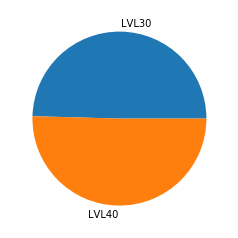

In [177]:
n_version = data.groupby(["version"]).agg("count")["userid"]
print("##################################\nPERCENTAGE OF USERS OF EACH VERSION\n##################################")
print("LVL30: {:.2f}% -- LVL40: {:.2f}%".format(n_version[0]/len(data),n_version[0]/len(data)))

plt.pie(n_version, labels = ["LVL30", "LVL40"])
plt.show()


The data is from 90,189 players that installed the game while the AB-test was running. It contains 5 different variables:

- *userid* - a unique number that identifies each player.
- *version* - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
- *sum_gamerounds* - the number of game rounds played by the player during the first week after installation
- *retention_1* - did the player come back and play 1 day after installing?
- *retention_7* - did the player come back and play 7 days after installing?


## A/B Testing Process


1. Understanding business problem & data
2. Detect and resolve problems in the data (Missing Value, Outliers, Unexpected Value)
3. Look summary stats and plots
4. Apply hypothesis testing and check assumptions
    + Check Normality & Homogeneity
    + Apply tests (Shapiro, Levene Test, T-Test, Welch Test, Mann Whitney U Test)
5. Evaluate the results
6. Make inferences
7. Recommend business decision to your customer/director/ceo etc.


## DIGGING DEEPER INTO DATA

In [178]:
# Are there any duplicated user IDs?
if len(np.unique(data["userid"])) == len(data):
    print("All userid are unique")

All userid are unique


In [179]:
# Information about gamerounds played by users:
data.describe()[["sum_gamerounds"]].T

,count,mean,std,min,25%,50%,75%,max
sum_gamerounds,90189.0,51.872457,195.050858,0.0,5.0,16.0,51.0,49854.0


In [180]:
# %of people that has played more than the mean;
sum(data.sum_gamerounds > np.mean(data.sum_gamerounds))/len(data) * 100

24.895497233587243

In [181]:
# %of people that has played more than 500 rounds;
sum(data.sum_gamerounds > 500)/len(data) * 100

0.9491179633879963

In [182]:
# Checking the higher values it seems there's an extreme value that could be considered an outlier
#It's 16 times higher than the second one.
sorted(data.sum_gamerounds, reverse=True)[:10]

[49854, 2961, 2640, 2438, 2294, 2251, 2156, 2124, 2063, 2015]

## Removing the "outlier"

In [183]:
# Removing the outlier:
data = data[data.sum_gamerounds != max(data.sum_gamerounds)]

In [47]:
# Let's divide A and B groups:
data.groupby("version").sum_gamerounds.agg(["count", "mean", "median", "std", "max"])

,count,mean,median,std,max
version,,,,,
gate_30,44699,51.342111,17,102.057598,2961
gate_40,45489,51.298776,16,103.294416,2640


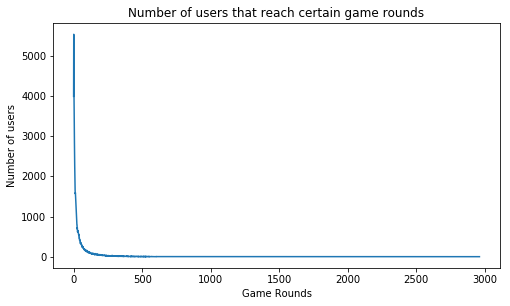

In [131]:
plt.figure(figsize = (8,4.5))
plt.plot(data.groupby("sum_gamerounds").userid.count())
plt.title("Number of users that reach certain game rounds")
plt.ylabel("Number of users")
plt.xlabel("Game Rounds")
plt.show()

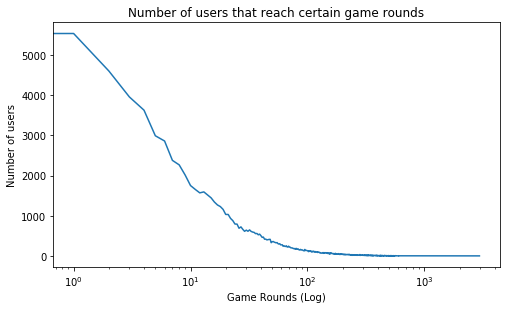

In [130]:
plt.figure(figsize = (8,4.5))
plt.plot(data.groupby("sum_gamerounds").userid.count())
plt.xscale("log")
plt.title("Number of users that reach certain game rounds")
plt.ylabel("Number of users")
plt.xlabel("Game Rounds (Log)")
plt.show()

The number of users that reach a certain number of game rounds decreases exponentially.<br>
It is important to check **how many users reach the gates 30 & 40**, since there is where the difference between A and B is.

In [65]:
data.groupby("sum_gamerounds").userid.count().loc[[30,40]]

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

In [76]:
#Retention_1 days after download by version
data.groupby("version").retention_1.agg(["count","mean","sum"])

,count,mean,sum
version,,,
gate_30,44699,0.448198,20034.0
gate_40,45489,0.442283,20119.0


In [75]:
#Retention_7 days after download by version
data.groupby("version").retention_7.agg(["count","mean","sum"])

,count,mean,sum
version,,,
gate_30,44699,0.190183,8501.0
gate_40,45489,0.182000,8279.0


<br>
Retention, a priori, seems better with the gate at lvl 30 than lvl 40
<br>

In [128]:
#We add a variable of "full retention", people that satisfy conditions retention_1 and retention_7
data["Full_retention"] = np.where((data.retention_1 == True) & (data.retention_7 == True), 1,0)
data.groupby(["version", "Full_retention"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

count  median        mean         std   max
version Full_retention                                             
A       0               38023      12   28.070273   48.017452  1072
        1                6676     127  183.886309  189.626390  2961
B       0               38983      12   28.103353   48.927850  2640
        1                6506     133  190.282355  194.220077  2294

In [107]:
#Total of gamerounds and full retention cases separated by version and retention/not
data_version = data.groupby(['version', 'Full_retention']).agg({'sum_gamerounds': 'sum', "Full_retention": 'count'})

In [108]:
data_version

sum_gamerounds  Full_retention
version Full_retention                                
gate_30 0                      1067316           38023
        1                      1227625            6676
gate_40 0                      1095553           38983
        1                      1237977            6506

In [103]:
#Total of gamerounds played and cases of each version. We are going to use this DF to get % in the previous one.
version = data.groupby(['version']).agg({'sum_gamerounds': 'sum', "Full_retention": 'count'})

In [104]:
version

,sum_gamerounds,Full_retention
version,,
gate_30,2294941,44699
gate_40,2333530,45489


In [109]:
#This is to get percentages, which are easier to interpret 
#We divide the data from table "data_version" by the total number of gamerounds and cases OF EACH VERSION.
#That's why every variable's percentages for each version add up to 100%
data_version.div(version, level='version') * 100

sum_gamerounds  Full_retention
version Full_retention                                
gate_30 0                    46.507339       85.064543
        1                    53.492661       14.935457
gate_40 0                    46.948314       85.697641
        1                    53.051686       14.302359

# A/B Test

### **Assumptions:**

+ Check normality
+ If Normal Distribution, check homogeneity

### **Steps:**

1. Split & Define Control Group & Test Group
2. Apply Shapiro Test for normality
       + H0: Distribution is Normal
       + H1: Distribution is NOT Normal
3. If Normal Distribution apply Levene Test for homogeneity of variances
       + H0: Homogeneity
       + H1: Heterogeneity
4. If Normal + Homogeneous Var apply T-Test
       + H0: M1 == M2
       + H1: M1 != M2
5. If Normal + Heterogeneous Var apply Welch Test
       + H0: M1 == M2
       + H1: M1 != M2
6. If Non-parametric apply Mann Whitney U Test directly
       + H0: M1 == M2
       + H1: M1 != M2


In [110]:
#Divide control (A) and test (B) groups
data["version"] = np.where(data.version == "gate_30", "A", "B")
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7,Full_retention
0,116,A,3,False,False,0
1,337,A,38,True,False,0
2,377,B,165,True,False,0
3,483,B,1,False,False,0
4,488,B,179,True,True,1


In [112]:
# Testing Game Rounds
groupA = data[data["version"] == "A"]["sum_gamerounds"]
groupB = data[data["version"] == "B"]["sum_gamerounds"]

In [117]:
shapiro(groupB)

(0.48256540298461914, 0.0)

In [122]:
# Check Normality of data:
# H0 is that Distribution is Normal. If pvalue is > 0.05
# H1 is that Distribution is not Normal. If pvaue is < 0.05
#p-value represents the "evidence" that confirms H0
normA = shapiro(groupA)[1] > 0.05
normB = shapiro(groupB)[1] > 0.05


In [123]:
print("That group A follows a Normal distribution is {}".format(normA))
print("That group B follows a Normal distribution is {}".format(normB))

That group A follows a Normal distribution is False
That group B follows a Normal distribution is False


<br>
Since the Shapiro test rejected H0 assumption of Normality, we need to apply a Non-parametric test: **Mann Whitney U Testing**.
<br>

In [127]:
#Mann Whitney U Testing. Non-Parametric
mwut = stats.mannwhitneyu(groupA, groupB)[1]

# #Path to follow if distributions are normal:
# leveneT = stats.levene(groupA, groupB)[1] < 0.05

# if LeveneT:
#     Ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
# if LeveneT == False:
#     Ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
    
print("p-value of Mann Whitney U Testing: {}".format(mwut))
if mwut > 0.05:
    print("There's not enough evidence to state there is a difference between groups")
else:
    print("There's significant evidence that proves A and B are different.")

p-value of Mann Whitney U Testing: 0.02544577639572688
There's significant evidence that proves A and B are different.


## CONCLUSION

After understanding the problem and the data given, an A/B Test was carried out and proved statistically that **the total number of game rounds is in fact affected by moving the gate** from lvl 30 to lvl 40. <br><br>
Below, the table shows the difference between the game rounds played with both configurations.

In [129]:
data.groupby("version").sum_gamerounds.agg(["count", "mean", "median", "std", "max"])

,count,mean,median,std,max
version,,,,,
A,44699,51.342111,17,102.057598,2961
B,45489,51.298776,16,103.294416,2640
